In [16]:
import pandas as pd 
import numpy as np 

In [17]:
train_test_df  = pd.read_csv('./titanic/train.csv')
serving_df = pd.read_csv('./titanic/test.csv')


In [18]:
serving_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
def preprocess(df):
    df = df.copy()
    
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)                     
    return df
    
preprocessed_train_test_df = preprocess(train_test_df)
preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_test_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


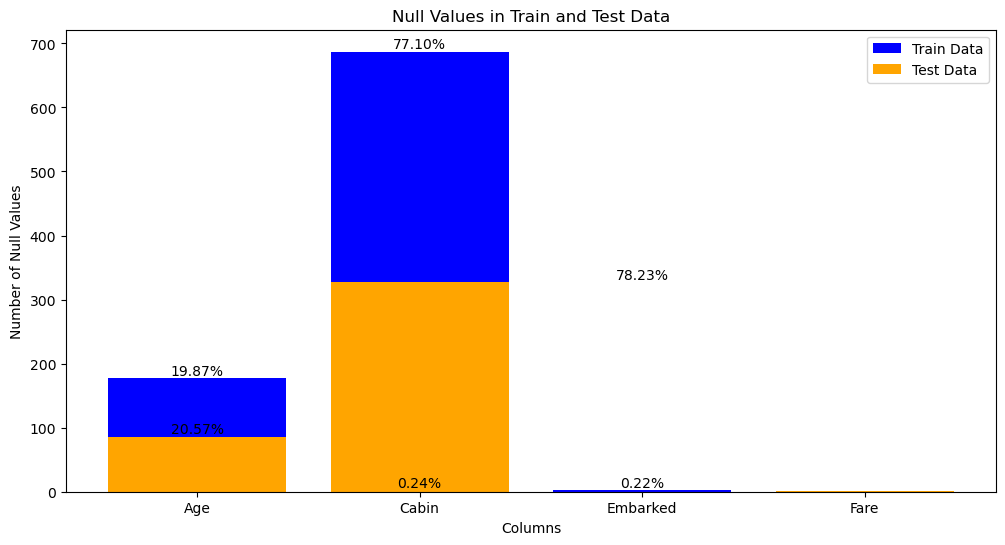

In [20]:
import matplotlib.pyplot as plt

train_null_values = {}
test_null_values = {}
total_test = preprocessed_serving_df.shape[0]
total_train = preprocessed_train_test_df.shape[0]

for cols in preprocessed_train_test_df.columns:
    if preprocessed_train_test_df[cols].isnull().sum() > 0:
        train_null_values[cols] = preprocessed_train_test_df[cols].isnull().sum()

for cols in preprocessed_serving_df.columns:
    if preprocessed_serving_df[cols].isnull().sum() > 0:
        test_null_values[cols] = preprocessed_serving_df[cols].isnull().sum()
    
plt.figure(figsize=(12, 6))
plt.bar(train_null_values.keys(), train_null_values.values(), label='Train Data', color='blue')

# Adding percentages to the bars
for i, value in enumerate(train_null_values.values()):
    plt.text(i, value + 5, f'{value / total_train * 100:.2f}%', ha='center')

# Plotting the null values for test data
plt.bar(test_null_values.keys(), test_null_values.values(), label='Test Data', color='orange')

# Adding percentages to the bars
for i, value in enumerate(test_null_values.values()):
    plt.text(i, value + 5, f'{value / total_test * 100:.2f}%', ha='center')

plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Null Values in Train and Test Data')
plt.legend()
plt.show()

In [21]:
def fillna(df):
    df.drop('Cabin', axis = 1, inplace = True)
    df.dropna(subset=["Embarked"],axis=0,how='any',inplace=True)
    df.fillna(train_test_df['Age'].mean(), inplace=True)
    df.fillna(train_test_df['Fare'].mean(), inplace=True)

    return df

processed_train_test_df = fillna(preprocessed_train_test_df)
processed_serving_df = fillna(preprocessed_serving_df)


In [22]:
print(processed_train_test_df.shape, processed_serving_df.shape)

(889, 13) (418, 12)


In [23]:
numerical_cols = preprocessed_train_test_df.select_dtypes(include=['number']).columns.tolist()
processed_train_test_df[numerical_cols].corrwith(processed_train_test_df['Survived'])

PassengerId   -0.005028
Survived       1.000000
Pclass        -0.335549
Age           -0.074673
SibSp         -0.034040
Parch          0.083151
Fare           0.255290
dtype: float64

In [57]:
Y = processed_train_test_df['Survived']
X = processed_train_test_df.drop(['Survived', 'PassengerId', 'Ticket'], axis = 1)
X_serving = processed_serving_df.drop(['Ticket'], axis = 1)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [28]:
(print(X_train.shape,y_train.shape, X_test.shape,y_test.shape))

(711, 10) (711,) (178, 10) (178,)


In [29]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]
print(categorical_features_indices)

[0 1 2 4 5 7 8 9]


In [30]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [36]:
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [37]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.029129
0:	learn: 0.6761485	test: 0.6798554	best: 0.6798554 (0)	total: 6.85ms	remaining: 6.85s
1:	learn: 0.6574102	test: 0.6643103	best: 0.6643103 (1)	total: 23.4ms	remaining: 11.7s
2:	learn: 0.6421659	test: 0.6524423	best: 0.6524423 (2)	total: 33.4ms	remaining: 11.1s
3:	learn: 0.6267436	test: 0.6410815	best: 0.6410815 (3)	total: 40.2ms	remaining: 10s
4:	learn: 0.6127740	test: 0.6319031	best: 0.6319031 (4)	total: 49.3ms	remaining: 9.82s
5:	learn: 0.5996743	test: 0.6224190	best: 0.6224190 (5)	total: 63.6ms	remaining: 10.5s
6:	learn: 0.5902192	test: 0.6164439	best: 0.6164439 (6)	total: 75.3ms	remaining: 10.7s
7:	learn: 0.5780416	test: 0.6076014	best: 0.6076014 (7)	total: 84.9ms	remaining: 10.5s
8:	learn: 0.5664877	test: 0.6002502	best: 0.6002502 (8)	total: 97.8ms	remaining: 10.8s
9:	learn: 0.5557465	test: 0.5935404	best: 0.5935404 (9)	total: 102ms	remaining: 10.1s
10:	learn: 0.5469809	test: 0.5880522	best: 0.5880522 (10)	total: 113ms	remaining: 10.2s
11:	learn: 0.53

In [43]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, Y, cat_features=categorical_features_indices),
    cv_params,
    logging_level='Verbose',
    nfold=5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.6742166	test: 0.6776825	best: 0.6776825 (0)	total: 18.2ms	remaining: 18.2s
1:	learn: 0.6606911	test: 0.6655919	best: 0.6655919 (1)	total: 27.1ms	remaining: 13.5s
2:	learn: 0.6470514	test: 0.6536963	best: 0.6536963 (2)	total: 30.8ms	remaining: 10.2s
3:	learn: 0.6326454	test: 0.6410857	best: 0.6410857 (3)	total: 35.6ms	remaining: 8.85s
4:	learn: 0.6149561	test: 0.6262646	best: 0.6262646 (4)	total: 44ms	remaining: 8.76s
5:	learn: 0.6012438	test: 0.6136462	best: 0.6136462 (5)	total: 52.3ms	remaining: 8.66s
6:	learn: 0.5933766	test: 0.6072829	best: 0.6072829 (6)	total: 56.7ms	remaining: 8.04s
7:	learn: 0.5822532	test: 0.5985371	best: 0.5985371 (7)	total: 64.5ms	remaining: 8s
8:	learn: 0.5723030	test: 0.5899969	best: 0.5899969 (8)	total: 71.1ms	remaining: 7.82s
9:	learn: 0.5628873	test: 0.5823339	best: 0.5823339 (9)	total: 75.6ms	remaining: 7.49s
10:	learn: 0.5520916	test: 0.5740244	best: 0.5740244 (10)	total: 82.3ms	remaining: 7.39s
11:	learn: 0.5427535	te

In [44]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.03 on step 130


In [40]:
print(cv_data)

     iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.676274          0.001573            0.675726   
1             1           0.660014          0.002840            0.659011   
2             2           0.645624          0.003535            0.643927   
3             3           0.631946          0.003320            0.629979   
4             4           0.619193          0.004136            0.617016   
..          ...                ...               ...                 ...   
995         995           0.419440          0.042123            0.128212   
996         996           0.419404          0.042053            0.128076   
997         997           0.419427          0.042287            0.127906   
998         998           0.419471          0.042244            0.127844   
999         999           0.419595          0.042245            0.127717   

     train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0             0.001028

In [46]:
model = CatBoostClassifier(
    l2_leaf_reg=1,
    learning_rate=0.0450866712211308,
    iterations=500,
    eval_metric=metrics.Accuracy(),
    random_seed=42,
    verbose=False,
    loss_function=metrics.Logloss(),
)


In [47]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7640449438
bestIteration = 142

Shrink model to first 143 iterations.


In [50]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, Y, cat_features=categorical_features_indices),
    cv_params,
    logging_level='Verbose',
    nfold=5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8426966292
bestIteration = 96

Training on fold [1/5]

bestTest = 0.808988764
bestIteration = 31

Training on fold [2/5]

bestTest = 0.893258427
bestIteration = 197

Training on fold [3/5]

bestTest = 0.8764044944
bestIteration = 485

Training on fold [4/5]

bestTest = 0.8305084746
bestIteration = 37



In [51]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))


Precise validation accuracy score: 0.8323747857550942


In [58]:
def prediction_to_kaggle_format(model, threshold=0.5):
    proba_survive = model.predict(X_serving, verbose=0)[:,0]
    return pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (proba_survive >= threshold).astype(int)
    })

submisstion['PassengerId'] = X_serving['PassengerId']
X_test = X_serving.drop('PassengerId',axis=1)
submisstion['Survived'] = model.predict(X_test)

In [62]:
submission = pd.DataFrame()
submission['PassengerId'] = X_serving['PassengerId']
X_test = X_serving.drop('PassengerId',axis=1)
submission['Survived'] = model.predict(X_test)

In [65]:
submission.to_csv('submission.csv', index=False)
